Data is located in gs://${GCS_BUCKET}/datasets.      
There should be bird, dog_breed, food, fungus, leaf folder.

The original zipped file is there.
The processed folder is also there

In [1]:
GCS_BUCKET = "np-training-public"


In [2]:
!gsutil ls gs://{GCS_BUCKET}/datasets

gs://np-training-public/datasets/bird/
gs://np-training-public/datasets/dog_breed/
gs://np-training-public/datasets/food/
gs://np-training-public/datasets/fungus/
gs://np-training-public/datasets/leaf/


In [3]:
#!mkdir -p data

# Download

In [4]:
import os

In [5]:
#!gsutil -m cp -r  gs://${GCS_BUCKET}/datasets/dog_breed/* data/

**Important: Choose a dataset you would like to work with**

In [6]:
# sorted by size of data
#DATASET_NAME = "dog_breed"
#DATASET_NAME = "leaf"
#DATASET_NAME = "food"
DATASET_NAME = "bird"
#DATASET_NAME = "fungus"


In [7]:
DATASET_PATH= os.path.expanduser(f"~/data/{DATASET_NAME}")

In [8]:
ls {DATASET_PATH}

aberts_towhee/                 house_wren/
acorn_woodpecker/              huttons_vireo/
allens_hummingbird/            inca_dove/
american_avocet/               indigo_bunting/
american_black_duck/           juniper_titmouse/
american_coot/                 killdeer/
american_crow/                 ladder-backed_woodpecker/
american_dipper/               lark_bunting/
american_goldfinch/            lark_sparrow/
american_kestrel/              laughing_gull/
american_oystercatcher/        lazuli_bunting/
american_pipit/                least_flycatcher/
american_redstart/             least_sandpiper/
american_robin/                lesser_goldfinch/
american_tree_sparrow/         lesser_scaup/
american_white_pelican/        lesser_yellowlegs/
american_wigeon/               lincolns_sparrow/
american_woodcock/             little_blue_heron/
anhinga/                       loggerhead_shrike/
annas_hummingbird/             long-billed_curlew/
ash-throated_flycatcher/       long-tailed_duck/
ba

In [9]:
import sys
sys.path.append("/home/ubuntu/fastai/")

In [10]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import helper


In [11]:
import pandas as pd
from tqdm import tqdm
import hashlib
from glob import glob


In [12]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

# Generate labels.csv

In [13]:
!pwd

/home/ubuntu/deep_learning_workshop/training


In [14]:
!rm -rf models
!mkdir models

In [15]:
BASE_PATH= DATASET_PATH

# iterate over all the images, parse "class name/folder" and "image name"
records = []
for image in glob(f"{BASE_PATH}/**/*.jpg"):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    records.append({
        "file": image,
        "class": species.replace(" ", "_")
    })

labels_df = pd.DataFrame(records)
os.makedirs(f'data/{DATASET_NAME}',exist_ok=True)
labels_df.to_csv(f'data/{DATASET_NAME}/labels.csv', index=False)

In [16]:
!ls

converted_model.tflite	     graph.lite		   model_benchmark
data			     helper.py		   models
dobgreed_mobilenet_tf.ipynb  keras.ipynb	   prep.ipynb
dobgreed_resnet.ipynb	     keras_parallel.ipynb  __pycache__
dog_breed.h5		     keras_parallel.py	   sector_labelling.ipynb
dog_breed.mlmodel	     labels.csv		   tensorflow_export.ipynb
dog_breed_tf.h5		     labels.txt		   tensorflow_tf_keras.ipynb
downloads		     MobileNet.ipynb	   tmp
fastai.ipynb		     model


In [17]:
labels_df.head()

class                                               file
0  mountain_bluebird  /home/ubuntu/data/bird/mountain_bluebird/d0cb3...
1  mountain_bluebird  /home/ubuntu/data/bird/mountain_bluebird/1f93b...
2  mountain_bluebird  /home/ubuntu/data/bird/mountain_bluebird/3d5f9...
3  mountain_bluebird  /home/ubuntu/data/bird/mountain_bluebird/3f4bd...
4  mountain_bluebird  /home/ubuntu/data/bird/mountain_bluebird/b336d...

**Number of unqiue categories **

In [18]:
num_classes = len(labels_df['class'].unique())
num_classes

404

In [19]:
labels_df['class'].value_counts()[0:10]

yellow-rumped_warbler    435
dark-eyed_junco          362
european_starling        308
red-tailed_hawk          298
american_goldfinch       240
northern_cardinal        240
red-winged_blackbird     239
white-crowned_sparrow    239
northern_flicker         238
mallard                  238
Name: class, dtype: int64

# View Sample Images

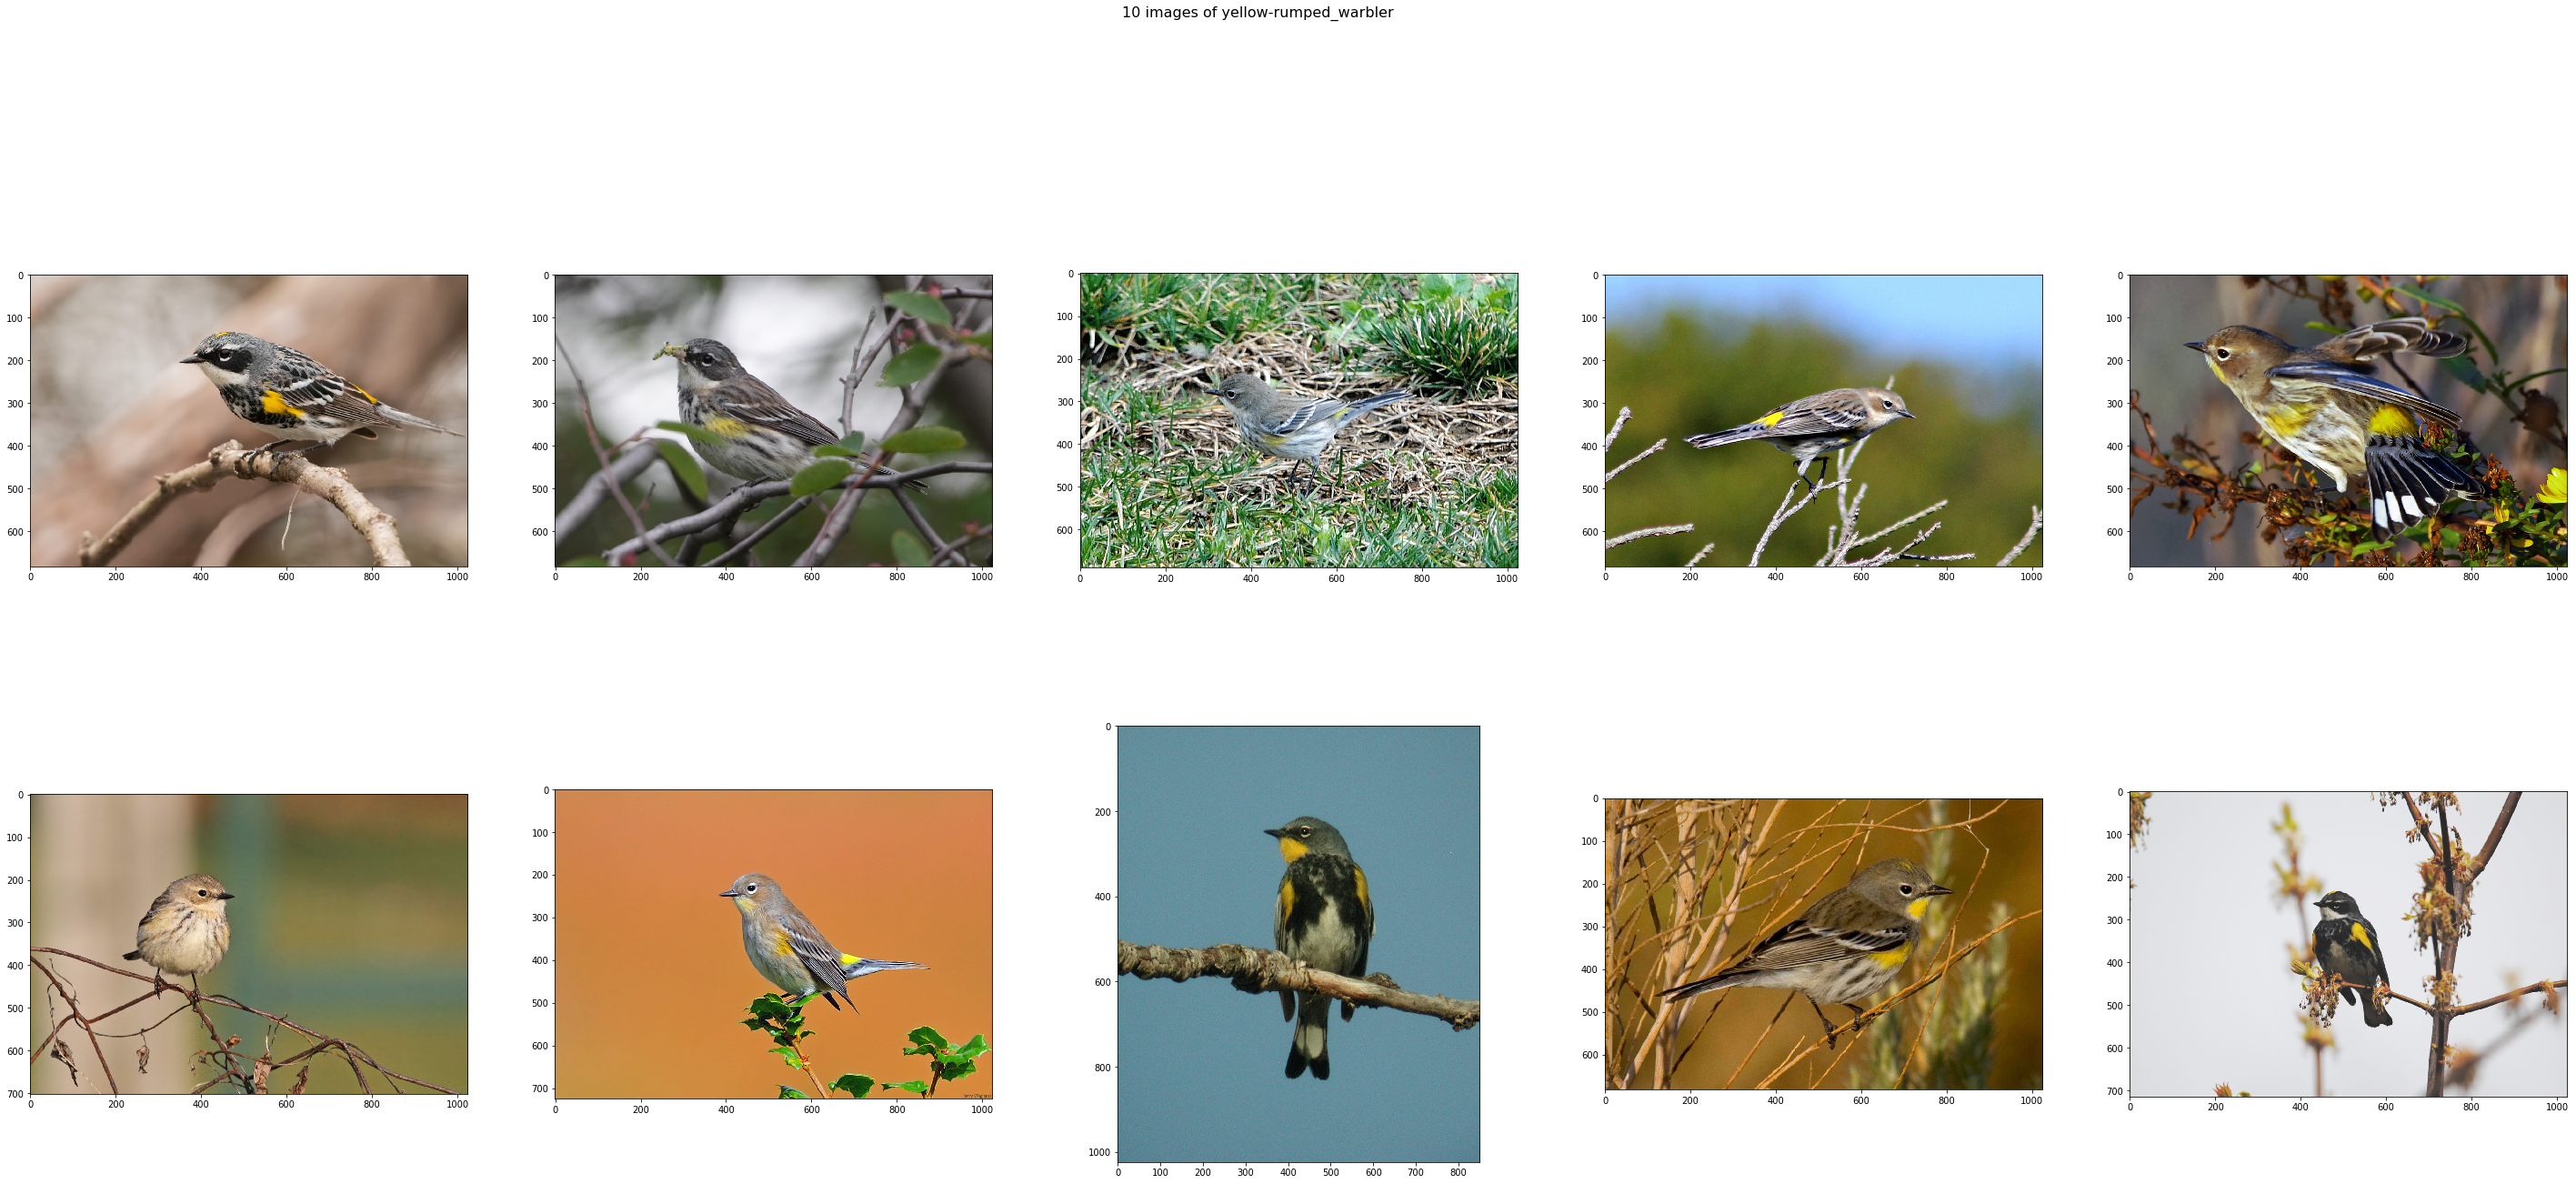

In [20]:
helper.display_images_from_class(labels_df,label='yellow-rumped_warbler',num_images=10 )

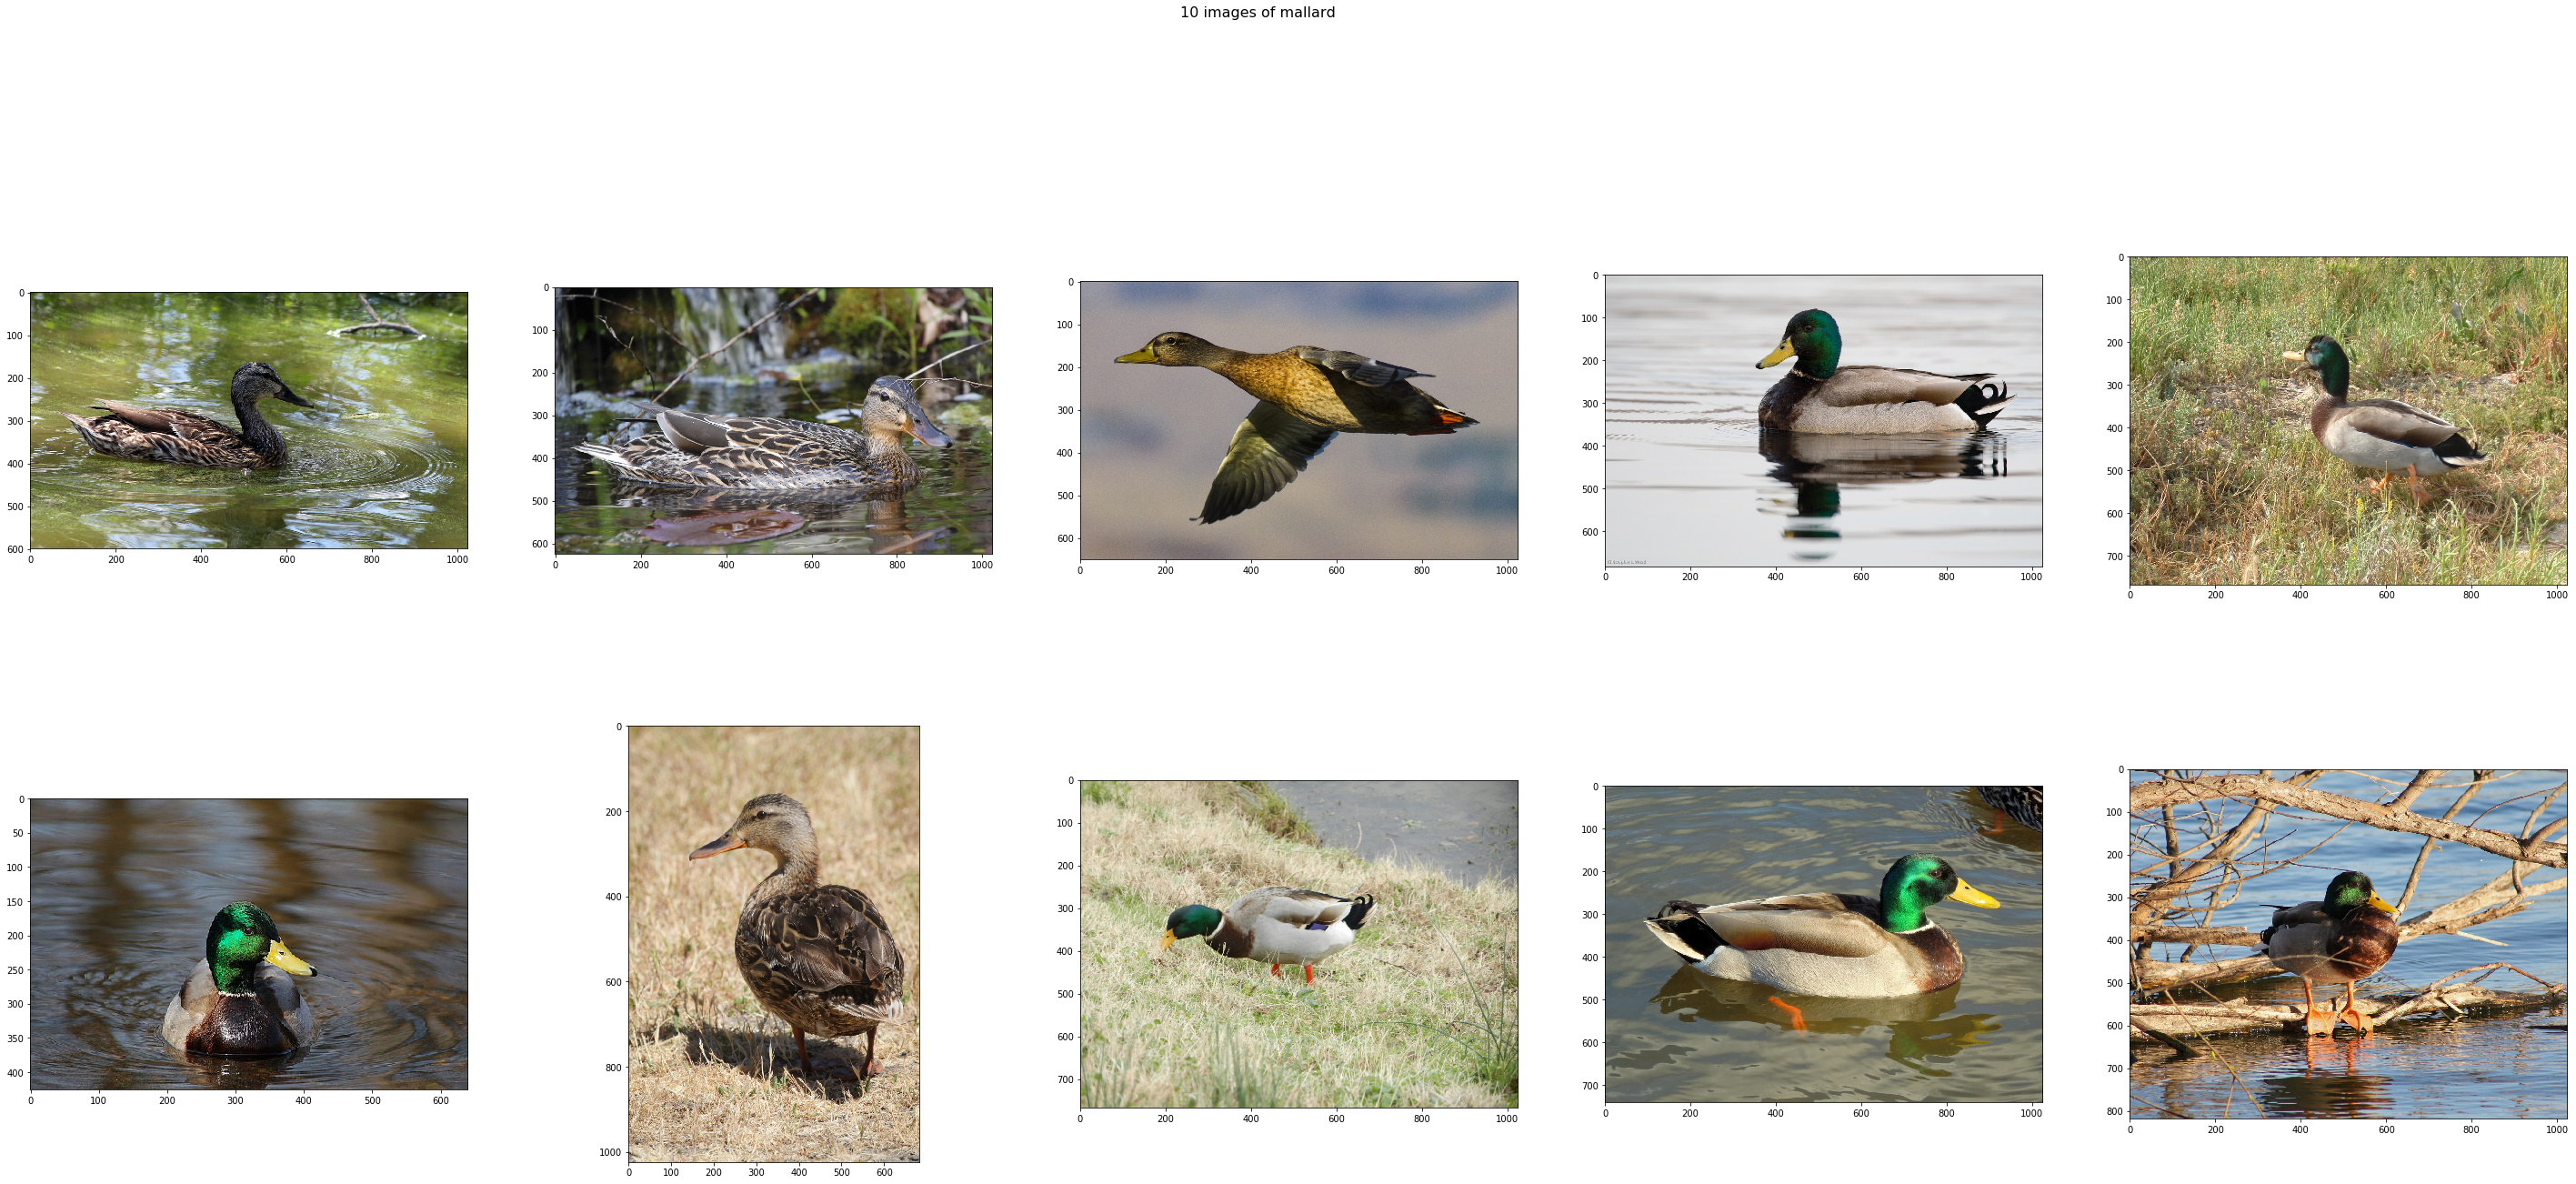

In [21]:
helper.display_images_from_class(labels_df,label='mallard',num_images=10 )

In [22]:
PATH = DATASET_PATH


**Save only first n classes **

In [23]:
n = num_classes
topn_classes = labels_df['class'].value_counts()[0:10].index.tolist()

In [24]:
labels_df=labels_df[labels_df['class'].isin(topn_classes)]

In [25]:
labels_df.to_csv(f'data/{DATASET_NAME}/labels.csv')

In [26]:
topn_classes

['yellow-rumped_warbler',
 'dark-eyed_junco',
 'european_starling',
 'red-tailed_hawk',
 'american_goldfinch',
 'northern_cardinal',
 'red-winged_blackbird',
 'white-crowned_sparrow',
 'northern_flicker',
 'mallard']

** Validation data **

In [27]:
label_csv = f'data/{DATASET_NAME}/labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)


# Save Subset

In [28]:
def save_images(list_images,dest='train'):
    for img_path in tqdm(list_images):
        paths = img_path.split("/")
        class_name, img_file = paths[-2],paths[-1]
        
        os.makedirs(f"{dest}/{class_name}",exist_ok=True)
        shutil.copy(img_path,f"{dest}/{class_name}/{img_file}")
        

In [29]:
shutil.rmtree(f'data/{DATASET_NAME}/train',ignore_errors=True)
shutil.rmtree(f'data/{DATASET_NAME}/valid',ignore_errors=True)

In [30]:
labels_df[~labels_df.index.isin(val_idxs)]['class'].value_counts()

yellow-rumped_warbler    435
dark-eyed_junco          362
european_starling        308
red-tailed_hawk          244
american_goldfinch       240
white-crowned_sparrow    239
red-winged_blackbird     239
northern_flicker         238
mallard                  238
northern_cardinal        190
Name: class, dtype: int64

In [31]:
train_set = labels_df[~labels_df.index.isin(val_idxs)]
save_images(train_set['file'], dest=f'data/{DATASET_NAME}/train')

save_images(labels_df.iloc[val_idxs]['file'], dest=f'data/{DATASET_NAME}/valid')


100%|██████████| 567/567 [00:00<00:00, 3352.84it/s]


In [32]:
train_set['class'].value_counts()

yellow-rumped_warbler    435
dark-eyed_junco          362
european_starling        308
red-tailed_hawk          244
american_goldfinch       240
white-crowned_sparrow    239
red-winged_blackbird     239
northern_flicker         238
mallard                  238
northern_cardinal        190
Name: class, dtype: int64

In [33]:
label_csv = f'labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [34]:
def save_images(list_images,dest='train'):
    for img_path in tqdm(list_images):
        paths = img_path.split("/")
        class_name, img_file = paths[-2],paths[-1]
        
        os.makedirs(f"{dest}/{class_name}",exist_ok=True)
        shutil.copy(img_path,f"{dest}/{class_name}/{img_file}")

In [35]:
shutil.rmtree('data/train',ignore_errors=True)
shutil.rmtree('data/valid',ignore_errors=True)

In [36]:
save_images(labels_df.iloc[val_idxs]['file'], dest='data/valid')
train_set = labels_df[~labels_df.index.isin(val_idxs)]
save_images(train_set['file'], dest='data/train')

100%|██████████| 2733/2733 [00:00<00:00, 3419.64it/s]
